# **Ambil data**

In [1]:
import gdown
import pandas as pd
import numpy as np

untuk mengunduh beberapa file CSV dari Google Drive serta membacanya ke dalam DataFrame Pandas, dan menyimpannya dalam satu list agar mudah dikelola dan dianalisis

In [2]:
# id file dataset dari drive
file_ids ={
    "18mCl7MCPuzcYSjrf8MZ9r4kRY0Tq5p5Z": "go_track_tracks",
    "1KEQk6cuXqhNYlxxeH4SaCtnGjWqw62Yu": "go_track_trackspoints",
}

# list kosong untuk menyimpan DF hasil pembacaan file
dfs = []

for files, nama in file_ids.items():

  # download file
  url = f"https://drive.google.com/uc?id={files}"
  gdown.download(url, f"{nama}.csv", quiet=False)

  # baca file
  df = pd.read_csv(f"{nama}.csv")

  # menyimpan DF ke dalam list dfs
  dfs.append(df)

Downloading...
From: https://drive.google.com/uc?id=18mCl7MCPuzcYSjrf8MZ9r4kRY0Tq5p5Z
To: /content/go_track_tracks.csv
100%|██████████| 11.1k/11.1k [00:00<00:00, 21.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KEQk6cuXqhNYlxxeH4SaCtnGjWqw62Yu
To: /content/go_track_trackspoints.csv
100%|██████████| 1.09M/1.09M [00:00<00:00, 39.3MB/s]


memuat dataset GoTrack ke dalam DataFrame dan mengecek ukuran data sebagai langkah awal sebelum dilakukan eksplorasi dan pemrosesan data lebih lanjut.

In [3]:
# membaca file
tracks = pd.read_csv("go_track_tracks.csv")
points = pd.read_csv("go_track_trackspoints.csv")

# menampilkan ukuran data
print("tracks:", tracks.shape)
print("points:", points.shape)

tracks: (163, 10)
points: (18107, 5)


# **Integration**

Rename columns

In [17]:
# mengganti nama kolom pada DF "tracks"
tracks = tracks.rename(columns={
    "id": "track_id",
    "speed": "track_avg_speed_kmh",
    "time": "track_duration_h",
    "distance": "track_distance_km"
})

# mengganti nama kolom pada DF points
points = points.rename(columns={
    "id": "point_id",
    "time": "timestamp"
})

Gabungkan kedua data

In [18]:
# melakukan merge (left join) DF
df = points.merge(
    tracks,
    on="track_id",
    how="left"
)

# menampilkan ukuran data setelah merge
print("setelah merge:", df.shape)
df.head()

setelah merge: (18107, 14)


,point_id,latitude,longitude,track_id,timestamp,id_android,track_avg_speed_kmh,track_duration_h,track_distance_km,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32,0,19.210586,0.138049,2.652,3,0,0,1,NaN
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37,0,19.210586,0.138049,2.652,3,0,0,1,NaN
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42,0,19.210586,0.138049,2.652,3,0,0,1,NaN
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47,0,19.210586,0.138049,2.652,3,0,0,1,NaN
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53,0,19.210586,0.138049,2.652,3,0,0,1,NaN


# **Pre-Processing**

Ambil kolom yang kami gunakan

In [19]:
# menentukan kolom yang akan digunakan
ambil_cols = [
    "point_id", "track_id", "timestamp",
    "latitude", "longitude",
    "track_avg_speed_kmh", "track_distance_km", "track_duration_h",
    "car_or_bus"
]

# memilih subset kolom dari DF
df = df[ambil_cols]

# menampilkan ukuran data setelah pemilihan kolom
print("setelah pilih kolom:", df.shape)

setelah pilih kolom: (18107, 9)


In [20]:
# mengubah kolom timestamp menjadi format datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# mengurutkan data berdasarkan perjalanan dan waktu
df = df.sort_values(["track_id", "timestamp"]).reset_index(drop=True)

df.isna().sum()

,0
point_id,0
track_id,0
timestamp,0
latitude,0
longitude,0
track_avg_speed_kmh,0
track_distance_km,0
track_duration_h,0
car_or_bus,0


Karena datanya sudah bersih, selanjutnya kami tambahkan data

In [21]:
# ubah timestamp ke format datetime agar bisa dibaca oleh sistem
df["timestamp"] = pd.to_datetime(df["timestamp"])

# mengurutkan perjalanan dan waktu
df = df.sort_values(["track_id", "timestamp"]).reset_index(drop=True)

menghitung delta t atau selisih berdasarkan waktu

In [22]:
# Selisih waktu
df["selisih_waktu"] = df.groupby("track_id")["timestamp"].diff().dt.total_seconds()

menghitung delta s atau selisih berdasarkan jarak (KM)

In [23]:
# mengambil koordinat titik sebelumnya dalam satu track
lat_sebelum = df.groupby("track_id")["latitude"].shift(1)
lon_sebelum = df.groupby("track_id")["longitude"].shift(1)

# menentukan jari-jari bumi
R = 6371.0

# convert derajat ke radian
lat1 = np.radians(lat_sebelum)
lon1 = np.radians(lon_sebelum)
lat2 = np.radians(df["latitude"])
lon2 = np.radians(df["longitude"])

# menghitung selisih lintang & bujur
dlat = lat2 - lat1
dlon = lon2 - lon1

# menghitung jarak menggunakan rumus haversine
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

# menyimpan hasul jarak ke DF
df["selisih_jarak"] = R * c

menghitung kecepatan instan untuk cek noise

In [24]:
# membuat mask untuk selisih waktu valid
mask_waktu = df["selisih_waktu"] > 0

# menghitung kecepatan instan
df.loc[mask_waktu, "kecepatan_instan"] = (
    df.loc[mask_waktu, "selisih_jarak"] /
    (df.loc[mask_waktu, "selisih_waktu"] / 3600.0)   # detik -> jam
)

In [25]:
df.head()

,point_id,track_id,timestamp,latitude,longitude,track_avg_speed_kmh,track_distance_km,track_duration_h,car_or_bus,selisih_waktu,selisih_jarak,kecepatan_instan
0,1,1,2014-09-13 07:24:32,-10.939341,-37.062742,19.210586,2.652,0.138049,1,NaN,NaN,NaN
1,2,1,2014-09-13 07:24:37,-10.939341,-37.062742,19.210586,2.652,0.138049,1,5.0,6.754664e-09,0.000005
2,3,1,2014-09-13 07:24:42,-10.939324,-37.062765,19.210586,2.652,0.138049,1,5.0,3.121273e-03,2.247317
3,4,1,2014-09-13 07:24:47,-10.939211,-37.062843,19.210586,2.652,0.138049,1,5.0,1.524692e-02,10.977785
4,5,1,2014-09-13 07:24:53,-10.938939,-37.062879,19.210586,2.652,0.138049,1,6.0,3.044704e-02,18.268222


# **Metode**

memilih satu perjalanan (track) tertentu dan menyiapkan data kecepatan instan berbasis waktu, sebagai langkah awal sebelum dilakukan visualisasi atau analisis lanjutan seperti filtering sinyal dan pemodelan error kecepatan.

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# mengambil daftra track_id yang memiliki kecepatan instan
id_kandidat = (
    df[df["kecepatan_instan"].notna()]["track_id"]
      .unique()
)

# Menentukan track yang akan dipilih
id_dipilih = 13

print("track id yang dipilih:", id_dipilih)

#Ambil data untuk track yang dipilih
data_track = (
    df[df["track_id"] == id_dipilih]   #filter per track
      .copy()
      .sort_values("timestamp")
)

#Buang baris yang kecepatan instannya NaN
data_track = data_track.dropna(subset=["kecepatan_instan"])

# menampilkan contoh data
print(data_track[["timestamp", "kecepatan_instan"]].head())

track id yang dipilih: 13
              timestamp  kecepatan_instan
501 2014-09-30 10:16:30          5.181430
502 2014-09-30 10:16:41          0.405495
503 2014-09-30 10:16:51          0.324977
504 2014-09-30 10:17:01          0.009099
505 2014-09-30 10:17:11          0.001683


ubah perdetik (harus konstan)

In [27]:
# menjadikan timestamp sebagai index
data_track = data_track.set_index("timestamp")

# mengambil sinyal kecepatan
v = data_track["kecepatan_instan"]

# menampilkan jumlah titik sampel
print("jumlah titik dari sample:", len(v))

jumlah titik dari sample: 179


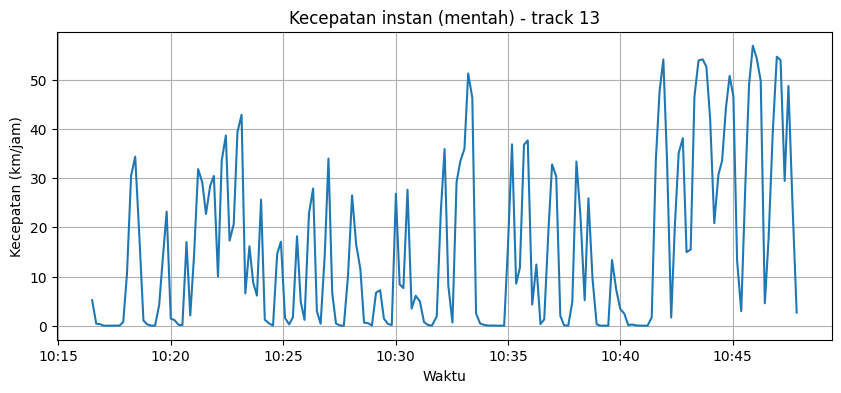

In [28]:
plt.figure(figsize=(10,4)) # membuat kanvas grafik
plt.plot(data_track.index, data_track["kecepatan_instan"]) # memplot kecepatan instan terhadap waktu
plt.title(f"Kecepatan instan (mentah) - track {id_dipilih}") # memberi judul grafik

# memberi label sumbu
plt.xlabel("Waktu")
plt.ylabel("Kecepatan (km/jam)")

plt.grid(True) # menambahkan grid

# mengatur format tampilan waktu pada sumbu x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.show() # menampilkan grafik


mengidentifikasi titik-titik kecepatan yang mengandung noise atau anomali berdasarkan lonjakan kecepatan yang terlalu besar antar waktu berurutan, sebagai langkah awal sebelum dilakukan filtering sinyal (misalnya Moving Average, Median Filter, atau Butterworth).

In [29]:
# menghitung selisih keccepatan antar waktu berturut-turut
data_track["diff_speed"] = data_track["kecepatan_instan"].diff()

# mendeteksi kandidat noise
kandidat_noise = data_track[data_track["diff_speed"].abs() > 20]

# menampilkan contoh kandidat noise
print(kandidat_noise[["kecepatan_instan", "diff_speed"]].head())

                     kecepatan_instan  diff_speed
timestamp                                        
2014-09-30 10:20:00          1.436594  -21.753520
2014-09-30 10:22:06          9.995223  -20.437510
2014-09-30 10:22:16         33.578730   23.583507
2014-09-30 10:22:37         17.305299  -21.343952
2014-09-30 10:23:19          6.573683  -36.285624


### **Butterworth** cek noise

menghaluskan sinyal kecepatan GPS menggunakan filter Butterworth low-pass, sehingga fluktuasi cepat (noise) dapat dikurangi dan pola kecepatan kendaraan

In [30]:
from scipy.signal import butter, filtfilt

# mengambil sinyal kecepatan mentah
v = data_track["kecepatan_instan"].values

# menentukan parameter sampling
Fs = 1.0
nyq = Fs / 2

# menentukan frekuensi cutoff
cutoff = 0.2
Wn = cutoff / nyq

# menentukan orde filter
orde = 3
b, a = butter(orde, Wn, btype="low")

# menerapkan filter ke sinyal
v_filtered_pertama = filtfilt(b, a, v)

# menyimpan hasil filtering
data_track["kecepatan_filter"] = v_filtered_pertama

membandingkan sinyal kecepatan GPS sebelum dan sesudah proses filtering Butterworth, sehingga efek pengurangan noise dan penghalusan sinyal dapat diamati secara visual dengan jelas.

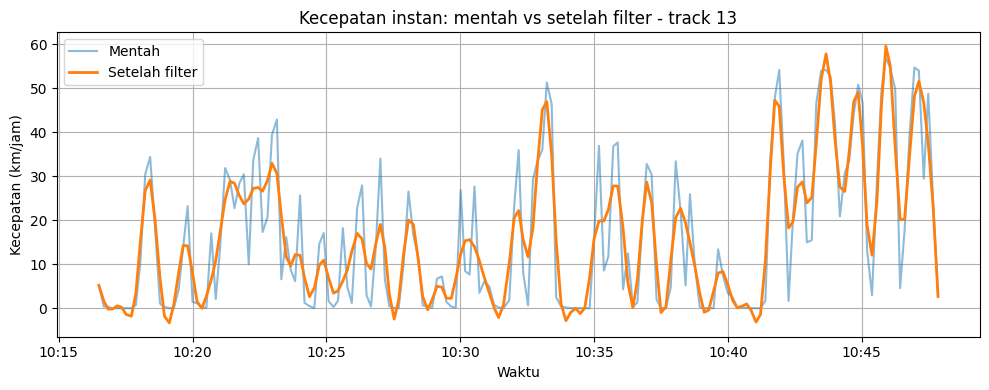

In [31]:
# membuat kanvas grafik
plt.figure(figsize=(10,4))

# memplot kecepatan instan mentah
plt.plot(data_track.index,
         data_track["kecepatan_instan"],
         label="Mentah", alpha=0.5)

# memplot kecepatan setelah filtering
plt.plot(data_track.index,
         data_track["kecepatan_filter"],
         label="Setelah filter", linewidth=2)

# memberi judul grafik
plt.title(f"Kecepatan instan: mentah vs setelah filter - track {id_dipilih}")

# memberi label sumbu
plt.xlabel("Waktu")
plt.ylabel("Kecepatan (km/jam)")

plt.grid(True) # menambahkan grid

# mengatur format waktu sumbu x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# menampilkan legenda
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error

WINDOW = 5 # menentukan ukuran jendela

# menyiapkan list penyimpanan
bw_pred = []
actual = []

# mengambil sinyal kecepatan hasil filter
signal = data_track['kecepatan_filter'].values

# proses prediksi berbasis sliding window
for i in range(len(signal) - WINDOW):
    window = signal[i:i+WINDOW]
    pred = np.mean(window)
    bw_pred.append(pred)
    actual.append(signal[i + WINDOW])

# mengonversi list ke array NumPy
bw_pred = np.array(bw_pred)
actual = np.array(actual)

# Simpan untuk sinkronisasi dengan LSTM
data_pred = data_track.iloc[WINDOW:].copy()
data_pred["pred_bw"] = bw_pred
data_pred["actual"] = actual

# menghitung RSME
rmse_bw = np.sqrt(mean_squared_error(actual, bw_pred))
print("RMSE – Butterworth (baseline):", rmse_bw)

RMSE – Butterworth (baseline): 12.915294600376898


## LSTM + Butterworth

In [33]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [34]:
v_raw = data_track["kecepatan_instan"].values # mengambil sinyal kecepatan mentah
v_bw  = data_track["kecepatan_filter"].values # mengambil sinyal kecepatan hasil filter Butetrworth

menyiapkan data kecepatan GPS hasil filtering menjadi dataset time series terawasi yang siap digunakan sebagai input model LSTM, dengan memanfaatkan histori kecepatan 60 detik untuk memprediksi kecepatan pada waktu berikutnya.

In [35]:
WINDOW = 60 # menentukan ukuran window

# menggunakan sinyal kecepatan yang sudah dihaluskan
series = v_bw.reshape(-1, 1)

# normalisasi
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# membuat fungsi pembentukan dataset time series
def create_dataset(series_scaled, window):
    X, y = [], []
    for i in range(len(series_scaled) - window):
        X.append(series_scaled[i : i + window])
        y.append(series_scaled[i + window])
    return np.array(X), np.array(y)

# membentuk dataset LSTM
X, y = create_dataset(series_scaled, WINDOW)

# mengubah bentuk input untuk LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# menampilkan ukuran data
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (119, 60, 1)
y shape: (119, 1)


membagi dataset time series menjadi data latih dan data uji secara kronologis, yang merupakan praktik penting dalam pemodelan deret waktu seperti LSTM agar evaluasi model tetap valid.

In [36]:
# menentukan proporsi data latih dan uji
split = int(0.8 * len(X))  # 80% train, 20% test

X_train, X_test = X[:split], X[split:] # membagi data input x
y_train, y_test = y[:split], y[split:] # membagi data input y

# menampilkan ukuran data
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (95, 60, 1)
X_test : (24, 60, 1)


memprediksi kecepatan kendaraan berbasis deret waktu, dengan memanfaatkan histori kecepatan selama WINDOW detik. Hasil prediksi (pred_lstm) selanjutnya dapat dibandingkan dengan nilai aktual atau dengan metode baseline (Butterworth / Moving Average) menggunakan metrik seperti RMSE.

In [37]:
# membangun arsitektur model
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

# kompilasi model
model.compile(optimizer='adam', loss='mse')

# melatih model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test)
)

# melakukan prediksi
pred_lstm = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


mengevaluasi performa model LSTM pada skala kecepatan asli, sehingga hasil error mudah diinterpretasikan dan dapat dibandingkan secara adil dengan metode prediksi lain yang digunakan dalam penelitian.

In [38]:
# mengembalikan data ke skala asli
y_test_inv      = scaler.inverse_transform(y_test)
pred_lstm_inv   = scaler.inverse_transform(pred_lstm)

# mengecek kesesuaian dimensi data
print("y_test_inv shape    :", y_test_inv.shape)
print("pred_lstm_inv shape :", pred_lstm_inv.shape)

# menghitung RMSE prediksi LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
print("RMSE Prediksi LSTM:", rmse_lstm)

y_test_inv shape    : (24, 1)
pred_lstm_inv shape : (24, 1)
RMSE Prediksi LSTM: 15.836439613144263


In [39]:
total_y = len(y) # jumlah total data target

# menentukan indeks awal dan akhir data uji
idx_start_test = WINDOW + split
idx_end_test   = WINDOW + total_y

# mengambil data uji dari sinyal asli dan hasil filtering
raw_test = v_raw[idx_start_test:idx_end_test]
bw_test  = v_bw[idx_start_test:idx_end_test]

# mengecek kesesuaian panjang data aktual dan prediksi
print(len(raw_test), len(bw_test), len(y_test_inv), len(pred_lstm_inv))

24 24 24 24


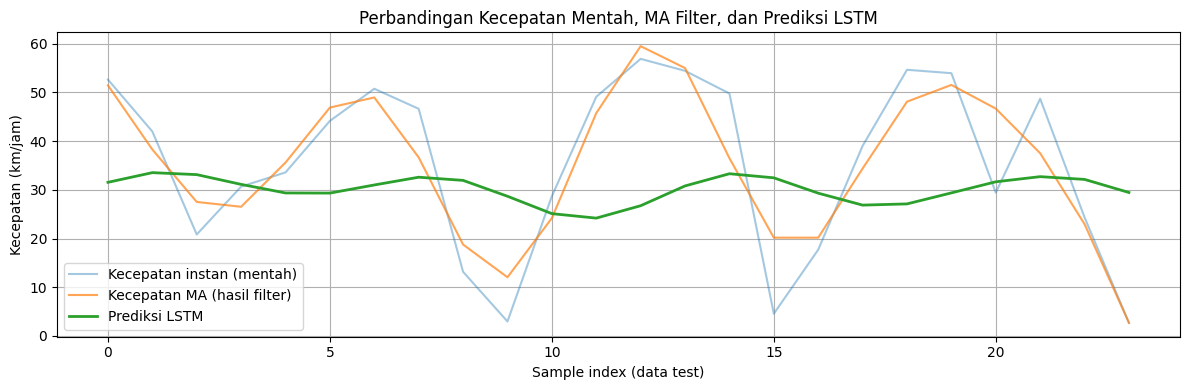

In [44]:
N = 200

plt.figure(figsize=(12,4))

# 1. sinyal mentah
plt.plot(raw_test[-N:], label="Kecepatan instan (mentah)", alpha=0.4)

# 2. hasil Moving Average
plt.plot(bw_test[-N:], label="Kecepatan MA (hasil filter)", alpha=0.7)

# 3. prediksi LSTM
plt.plot(pred_lstm_inv[-N:], label="Prediksi LSTM", linewidth=2)

plt.title("Perbandingan Kecepatan Mentah, MA Filter, dan Prediksi LSTM")
plt.xlabel("Sample index (data test)")
plt.ylabel("Kecepatan (km/jam)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Moving Average

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [50]:
print("track id yang dipilih:", id_dipilih)

#Ambil data untuk track yang dipilih
data_track = (
    df[df["track_id"] == id_dipilih]   #filter per track
      .copy()
      .sort_values("timestamp")
)

#Buang baris yang kecepatan instannya NaN
data_track = data_track.dropna(subset=["kecepatan_instan"])

print(data_track[["timestamp", "kecepatan_instan"]].head())

track id yang dipilih: 13
              timestamp  kecepatan_instan
501 2014-09-30 10:16:30          5.181430
502 2014-09-30 10:16:41          0.405495
503 2014-09-30 10:16:51          0.324977
504 2014-09-30 10:17:01          0.009099
505 2014-09-30 10:17:11          0.001683


In [51]:
# fungsi moving average untuk menghaluskan sinyal
def moving_average(signal, window_size=5):
    signal = np.array(signal)
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# menerapkan moving average pada data kecepatan instan
data_track["kecepatan_MA"] = moving_average(data_track["kecepatan_instan"])

In [52]:
# mengubah kolom timestamp ke format datetime
data_track['timestamp'] = pd.to_datetime(data_track['timestamp'])

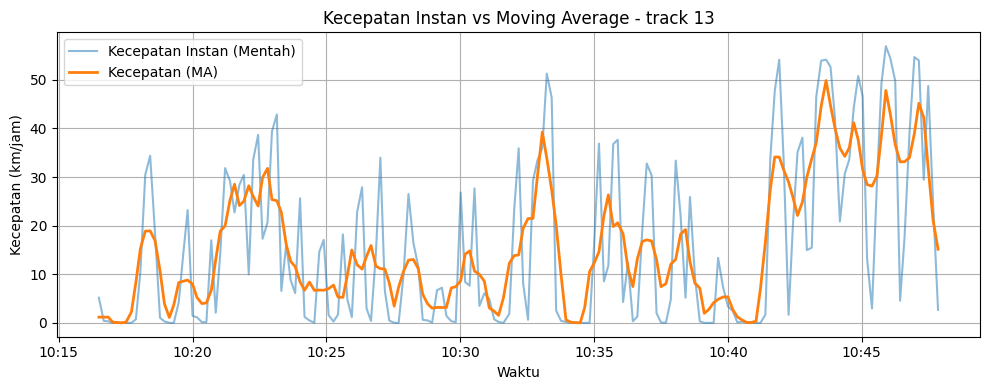

In [53]:
plt.figure(figsize=(10,4)) # membuat figure plot

# plot kecepatan instan (mentah) dan hasil moving average
plt.plot(data_track["timestamp"], data_track["kecepatan_instan"], label="Kecepatan Instan (Mentah)", alpha=0.5)
plt.plot(data_track["timestamp"], data_track["kecepatan_MA"], label="Kecepatan (MA)", linewidth=2)

# memberi judul dan label sumbu
plt.title(f"Kecepatan Instan vs Moving Average - track {id_dipilih}")
plt.xlabel("Waktu")
plt.ylabel("Kecepatan (km/jam)")
plt.grid(True) # menampilkan grid

# mengatur format waktu pada sumbu x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# menampilkan legenda dan plot
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
# menentukan ukuran window MA
WINDOW = 5
ma_pred = []
actual = []

# mengambil sinyal hasil moving average
signal = data_track['kecepatan_MA'].values

# membuat prediksi MA dan nilai aktual
for i in range(len(signal) - WINDOW):
    window = signal[i:i+WINDOW]
    pred = np.mean(window)
    ma_pred.append(pred)
    actual.append(signal[i + WINDOW])

# mengubah ke array numpy
ma_pred = np.array(ma_pred)
actual = np.array(actual)

# Simpan untuk sinkronisasi dengan LSTM
data_pred = data_track.iloc[WINDOW:].copy()
data_pred["pred_MA"] = ma_pred
data_pred["actual"] = actual

# menghitung RMSE sebagai baseline Moving Average
rmse_ma = np.sqrt(mean_squared_error(actual, ma_pred))
print("RMSE – Moving Average (baseline):", rmse_ma)

RMSE – Moving Average (baseline): 8.02101818365616


## LSTM + MA

In [55]:
!pip install tensorflow

In [56]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [57]:
v_raw = data_track["kecepatan_instan"].values
v_ma  = data_track["kecepatan_MA"].values

In [58]:
WINDOW = 60

# pakai sinyal halus (MA)
series = v_ma.reshape(-1, 1)

# normalisasi
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def create_dataset(series_scaled, window):
    X, y = [], []
    for i in range(len(series_scaled) - window):
        X.append(series_scaled[i : i + window])
        y.append(series_scaled[i + window])
    return np.array(X), np.array(y)

X, y = create_dataset(series_scaled, WINDOW)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (119, 60, 1)
y shape: (119, 1)


In [ ]:
split = int(0.8 * len(X))  # 80% train, 20% test

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (95, 60, 1)
X_test : (24, 60, 1)


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test)
)

pred_lstm = model.predict(X_test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [ ]:
y_test_inv      = scaler.inverse_transform(y_test)
pred_lstm_inv   = scaler.inverse_transform(pred_lstm)

print("y_test_inv shape    :", y_test_inv.shape)
print("pred_lstm_inv shape :", pred_lstm_inv.shape)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
print("RMSE Prediksi LSTM:", rmse_lstm)


y_test_inv shape    : (24, 1)
pred_lstm_inv shape : (24, 1)
RMSE Prediksi LSTM: 9.13593818699409


In [ ]:
total_y = len(y)

idx_start_test = WINDOW + split
idx_end_test   = WINDOW + total_y

raw_test = v_raw[idx_start_test:idx_end_test]
ma_test  = v_ma[idx_start_test:idx_end_test]

print(len(raw_test), len(ma_test), len(y_test_inv), len(pred_lstm_inv))


24 24 24 24


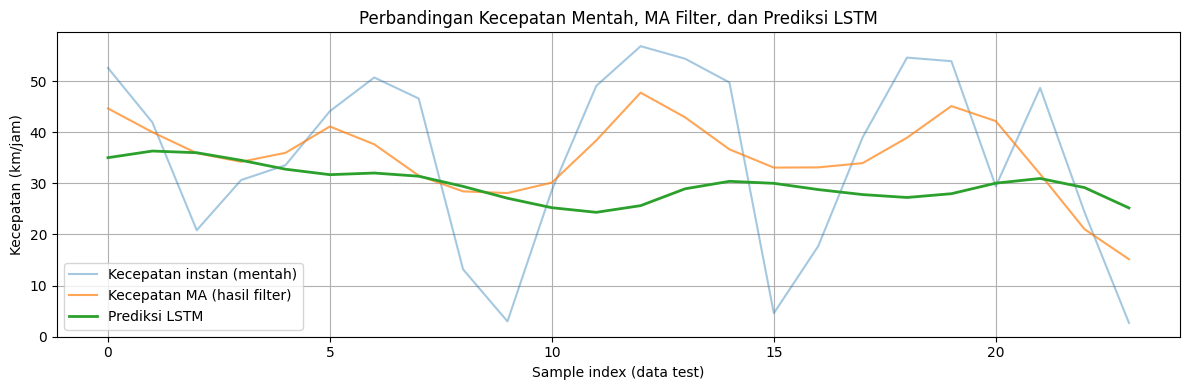

In [ ]:
N = 200

plt.figure(figsize=(12,4))

# 1. sinyal mentah
plt.plot(raw_test[-N:], label="Kecepatan instan (mentah)", alpha=0.4)

# 2. hasil Moving Average
plt.plot(ma_test[-N:], label="Kecepatan MA (hasil filter)", alpha=0.7)

# 3. prediksi LSTM
plt.plot(pred_lstm_inv[-N:], label="Prediksi LSTM", linewidth=2)

plt.title("Perbandingan Kecepatan Mentah, MA Filter, dan Prediksi LSTM")
plt.xlabel("Sample index (data test)")
plt.ylabel("Kecepatan (km/jam)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Median Filter

In [59]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt

# mengambil data berdasarkan track_id terpilih
data_track = (
    df[df["track_id"] == id_dipilih]
      .copy()
)

# mengubah timestamp ke datetime
data_track["timestamp"] = pd.to_datetime(data_track["timestamp"])

data_track["timestamp"] = pd.to_datetime(data_track["timestamp"])

# menjadikan timestamp sebagai index dan mengurutkannya
data_track = (
    data_track
      .set_index("timestamp")
      .sort_index()
)

# menampilkan jumlah data dan beberapa baris awal
print("Jumlah titik:", len(data_track))
data_track[["track_id", "kecepatan_instan"]].head()

Jumlah titik: 180


,track_id,kecepatan_instan
timestamp,,
2014-09-30 10:16:20,13,NaN
2014-09-30 10:16:30,13,5.181430
2014-09-30 10:16:41,13,0.405495
2014-09-30 10:16:51,13,0.324977
2014-09-30 10:17:01,13,0.009099


In [60]:
# mengambil sinyal kecepatan instan
v_raw = data_track["kecepatan_instan"].values

# menentukan ukuran window median filter
window_med = 5

# menerapkan median filter
v_med = medfilt(v_raw, kernel_size=window_med)

# menyimpan hasil median filter ke dataframe
data_track["kecepatan_median"] = v_med

# menampilkan beberapa data awal
data_track[["kecepatan_instan", "kecepatan_median"]].head()

,kecepatan_instan,kecepatan_median
timestamp,,
2014-09-30 10:16:20,NaN,0.405495
2014-09-30 10:16:30,5.181430,0.405495
2014-09-30 10:16:41,0.405495,0.405495
2014-09-30 10:16:51,0.324977,0.324977
2014-09-30 10:17:01,0.009099,0.020524


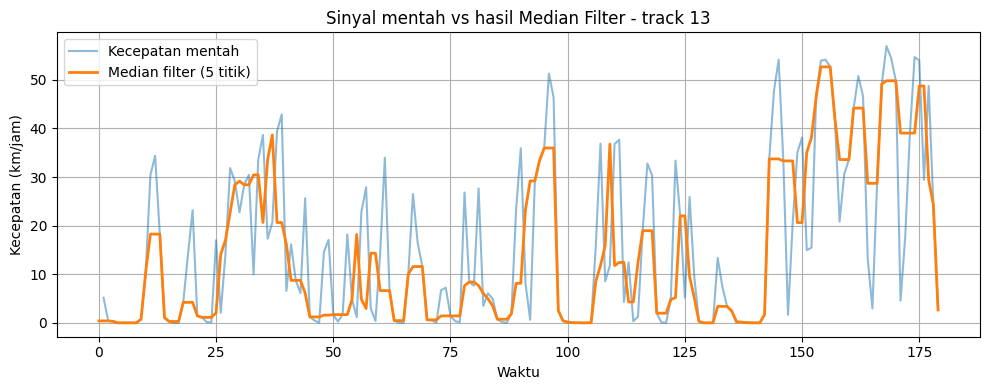

In [61]:
plt.figure(figsize=(10,4)) # membuat figure plot


# plot sinyal mentah dan hasil median filter
plt.plot(v_raw, label="Kecepatan mentah", alpha=0.5)
plt.plot(v_med, label=f"Median filter ({window_med} titik)", linewidth=2)

# memberi judul dan label sumbu
plt.title(f"Sinyal mentah vs hasil Median Filter - track {id_dipilih}")
plt.xlabel("Waktu")
plt.ylabel("Kecepatan (km/jam)")

# menampilkan grid, legenda, dan plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# menentukan ukuran window
WINDOW = 5
med_pred = []
actual = []

# mengambil sinyal hasil median filter
signal = data_track['kecepatan_median'].values

# membuat prediksi baseline dari median filter
for i in range(len(signal) - WINDOW):
    window = signal[i:i+WINDOW]
    pred = np.mean(window)
    med_pred.append(pred)
    actual.append(signal[i + WINDOW])

# mengubah ke array numpy
med_pred = np.array(med_pred)
actual = np.array(actual)

# Simpan untuk sinkronisasi dengan LSTM
data_pred = data_track.iloc[WINDOW:].copy()
data_pred["pred_med"] = med_pred
data_pred["actual"] = actual

# menghitung RMSE baseline median filter
rmse_med = np.sqrt(mean_squared_error(actual, med_pred))
print("RMSE – median_filter (baseline):", rmse_med)

RMSE – median_filter (baseline): 10.441995188188915


## LSTM + Median Filter

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
v_raw = data_track["kecepatan_instan"].values
v_med  = data_track["kecepatan_median"].values

In [ ]:
WINDOW = 60

# pakai sinyal halus (Median Filter)
series = v_med.reshape(-1, 1)

# normalisasi
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def create_dataset(series_scaled, window):
    X, y = [], []
    for i in range(len(series_scaled) - window):
        X.append(series_scaled[i : i + window])
        y.append(series_scaled[i + window])
    return np.array(X), np.array(y)

X, y = create_dataset(series_scaled, WINDOW)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (120, 60, 1)
y shape: (120, 1)


In [ ]:
split = int(0.8 * len(X))  # 80% train, 20% test

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (96, 60, 1)
X_test : (24, 60, 1)


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test)
)

pred_lstm = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


In [ ]:
y_test_inv      = scaler.inverse_transform(y_test)
pred_lstm_inv   = scaler.inverse_transform(pred_lstm)

print("y_test_inv shape    :", y_test_inv.shape)
print("pred_lstm_inv shape :", pred_lstm_inv.shape)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
print("RMSE Prediksi LSTM:", rmse_lstm)

y_test_inv shape    : (24, 1)
pred_lstm_inv shape : (24, 1)
RMSE Prediksi LSTM: 11.037786751838874


In [ ]:
total_y = len(y)

idx_start_test = WINDOW + split
idx_end_test   = WINDOW + total_y

raw_test = v_raw[idx_start_test:idx_end_test]
med_test  = v_med[idx_start_test:idx_end_test]

print(len(raw_test), len(med_test), len(y_test_inv), len(pred_lstm_inv))

24 24 24 24


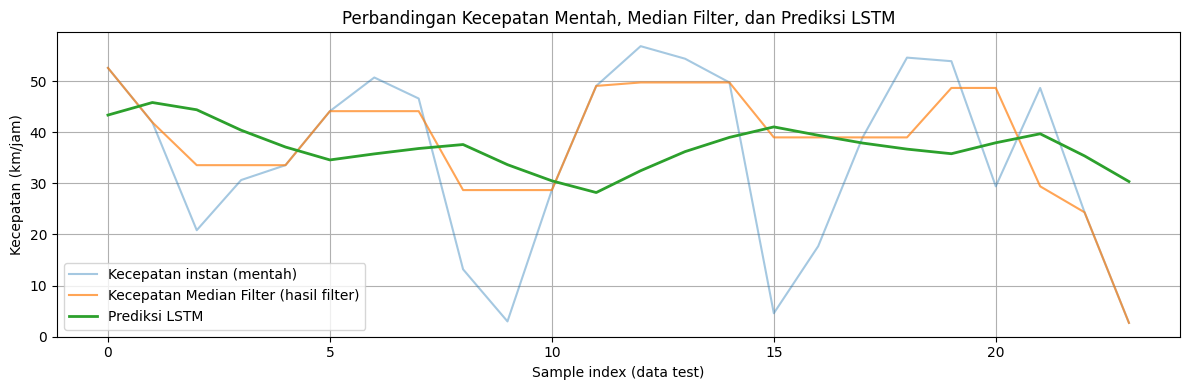

In [ ]:
N = 200

plt.figure(figsize=(12,4))

# 1. sinyal mentah
plt.plot(raw_test[-N:], label="Kecepatan instan (mentah)", alpha=0.4)

# 2. hasil Moving Average
plt.plot(med_test[-N:], label="Kecepatan Median Filter (hasil filter)", alpha=0.7)

# 3. prediksi LSTM
plt.plot(pred_lstm_inv[-N:], label="Prediksi LSTM", linewidth=2)

plt.title("Perbandingan Kecepatan Mentah, Median Filter, dan Prediksi LSTM")
plt.xlabel("Sample index (data test)")
plt.ylabel("Kecepatan (km/jam)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()